In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import opensmile
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbpipeline
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score 

In [2]:
voice_train = pd.read_pickle("./audio_tables/voice_train_split_df")
voice_test = pd.read_pickle("./audio_tables/voice_test_split_df")
voice_test_mismatch = pd.read_pickle("./combined_voice_votes_incorrect")

In [4]:
def extract_opensmile_features(voice_data):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    return smile.process_files(['./CREMA-D/AudioWAV/'+name+'.wav' for name in list(voice_data.fileName)])

def preprocess_audio_df(voice_data, labelencoder, scaler):
    voice_data_os = extract_opensmile_features(voice_data)
    
    voice_data_os.index = [i[0].split("/")[-1] for i in voice_data_os.index]
    voice_data_os["intendedEmo"] = list(voice_data.intendedEmo)
    
    voice_data_os["intendedEmo"] = labelencoder.fit_transform(voice_data_os["intendedEmo"])
    
    
    normalised_voice_data_os = voice_data_os.drop(columns=["intendedEmo"])
    normalised_voice_data_os.values[:] = scaler.fit_transform(voice_data_os.drop(columns=["intendedEmo"]))
    normalised_voice_data_os["intendedEmo"] = voice_data_os["intendedEmo"]
    return normalised_voice_data_os

In [3]:
stand_voice_train_os = pd.read_pickle("./audio_tables/voice_train_os_clean_stand_df")
stand_voice_train_os

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,intendedEmo
1008_IEO_DIS_HI.wav,0.439099,0.787897,-0.739809,-0.470666,-0.035187,0.088394,0.077497,0.165649,0.140058,-0.437544,...,0.279893,0.337219,0.425537,-0.974396,0.970025,-0.733060,0.469536,1.286007,1.717811,1
1049_ITS_FEA_XX.wav,-1.102518,-1.447464,1.254327,0.142384,-0.515158,-0.806938,-0.610930,-0.919811,-0.852371,0.877000,...,-0.542353,-0.269392,-0.418441,0.889723,-0.122289,0.939695,0.518701,-0.547081,-0.343164,2
1028_IEO_DIS_MD.wav,-0.558804,-0.989004,-0.447558,-0.274413,-0.284902,-0.402755,-0.250220,-0.439416,-0.389986,-0.117043,...,-1.734467,-0.218927,-0.160573,-0.999947,0.414975,0.654453,0.378362,-0.369701,1.135657,1
1091_WSI_ANG_XX.wav,-0.338160,-0.542935,1.167398,-0.961800,-0.337301,-0.367979,-0.138168,-0.346938,-0.283359,-2.176616,...,1.458850,-0.570340,-0.578497,1.031066,-0.980812,0.034837,0.135216,-0.508290,0.478146,0
1029_MTI_ANG_XX.wav,1.661620,2.061663,-0.644501,0.106400,0.986653,1.767341,1.075993,2.114871,1.823937,-0.319147,...,-0.916606,1.092121,1.033639,1.010465,0.095603,-0.023326,-0.967416,-0.129440,0.788355,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014_WSI_ANG_XX.wav,1.761778,0.044257,1.517341,-0.289577,1.400190,0.751368,1.636318,0.204493,0.809779,-0.043118,...,0.196905,0.047193,0.013608,1.024314,-0.017307,0.068796,-0.205993,-0.585876,0.153694,0
1011_WSI_NEU_XX.wav,-0.787726,-0.198785,1.081707,-0.347564,-0.714811,-0.807942,-0.712408,-0.779999,-0.803147,-0.114530,...,1.247074,-0.198444,-0.186812,-1.032092,0.079827,0.268868,0.244455,0.047784,0.789737,4
1025_WSI_ANG_XX.wav,0.083992,2.133975,-0.904081,0.674331,0.292919,-0.069286,0.159925,-0.317774,-0.141115,0.001475,...,-1.188668,0.759640,0.638398,0.944452,1.455840,1.139872,1.156480,0.609183,-0.650907,0
1064_TSI_DIS_XX.wav,-0.632279,2.142849,1.073221,-0.313794,-0.633436,-0.668051,-0.629868,-0.614923,-0.661377,0.277478,...,-0.158454,-0.797370,-0.754337,-1.010118,0.534796,-0.502788,-0.675912,-0.074270,0.109398,1


In [4]:
y_train = stand_voice_train_os.intendedEmo
X_train = stand_voice_train_os.drop(columns=["intendedEmo"])

In [5]:
voice_train_X, voice_train_y = X_train, y_train

In [8]:
voice_train_y.value_counts()

4    832
0    616
2    326
1    274
3    264
5    167
Name: intendedEmo, dtype: int64

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
import random

random.seed(4)

class UseNoiseData(BaseEstimator, TransformerMixin):
    """Custom function created for gridsearchCV that swaps the train data for augmented noise data
    and leaves validation data clean.
    """
    def __init__(self, noise_data, percentage):
        self.noise_data = noise_data
        self.percentage = percentage
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        num_to_augment = int(len(X)*self.percentage)
        items_to_augment = list(X.iloc[:num_to_augment].index)
        augmented_items = self.noise_data.loc[self.noise_data.index.isin(items_to_augment)]
        non_augmented_items = X.iloc[num_to_augment:]
        return pd.concat([augmented_items, non_augmented_items])

## Train on shift + noise data at SNR 10

In [7]:
stand_voice_train_os_shno10 = pd.read_pickle("./audio_tables/voice_train_os_shno10_stand_df")
stand_voice_train_os_shno10

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,intendedEmo
1008_IEO_DIS_HI.wav,0.248297,0.512852,0.180678,0.230186,0.187417,0.168000,0.059499,0.127662,0.129943,0.238376,...,0.632509,0.493823,0.469755,0.995478,0.356346,0.525868,0.544598,0.451566,0.385985,1
1049_ITS_FEA_XX.wav,0.011984,0.138197,0.997457,0.072127,0.060873,0.039114,0.038542,0.017597,0.024769,0.077744,...,0.305860,0.257442,0.240409,1.000000,0.492795,0.262380,0.148066,0.174067,0.237869,2
1028_IEO_DIS_MD.wav,0.093831,0.146789,0.952395,0.135115,0.117328,0.095633,0.071440,0.064836,0.075607,0.134099,...,0.249672,0.569565,0.557123,0.003033,0.594554,0.409109,0.432586,0.566394,0.352885,1
1091_WSI_ANG_XX.wav,0.126336,0.418901,0.925329,0.130246,0.116006,0.094252,0.081285,0.063620,0.076848,0.133049,...,0.411401,0.297117,0.291050,0.023294,0.474566,0.465606,0.517939,0.438943,0.323657,0
1029_MTI_ANG_XX.wav,0.709909,0.814175,0.000000,0.659602,0.554389,0.446936,0.210847,0.266535,0.292422,0.665114,...,0.393376,0.540730,0.529868,0.005869,0.531956,0.495632,0.398943,0.652537,0.414114,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014_WSI_ANG_XX.wav,0.560469,0.369932,0.040653,0.444455,0.394777,0.297661,0.233788,0.152982,0.194538,0.455284,...,0.510390,0.638263,0.614773,0.998484,0.413648,0.460865,0.352957,0.642953,0.508955,0
1011_WSI_NEU_XX.wav,0.064303,0.512831,0.007012,0.064710,0.050488,0.038144,0.019442,0.026832,0.028621,0.064750,...,0.554307,0.451029,0.457584,0.063986,0.185937,0.463865,0.426743,0.417860,0.394144,4
1025_WSI_ANG_XX.wav,0.186302,0.658509,0.993167,0.213252,0.191476,0.143838,0.129009,0.077390,0.100757,0.214068,...,0.438365,0.317671,0.282024,0.944829,0.804801,0.293181,0.223590,0.389927,0.281901,0
1064_TSI_DIS_XX.wav,0.084075,0.824352,0.061935,0.090919,0.071653,0.049238,0.023662,0.025346,0.028275,0.092896,...,0.443311,0.224995,0.219800,0.029276,0.424879,0.325040,0.301618,0.267901,0.172121,1


In [11]:
# defining parameter range
param_grid = {'classifier__C': [0.1, 1, 10, 100, 1000], 
              'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'classifier__kernel': ['rbf']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline_shno10 = imbpipeline(steps = [['noise', UseNoiseData(stand_voice_train_os_shno10.drop(columns=["intendedEmo"]), 1)],
                                ['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid_shno10 = GridSearchCV(
    estimator=pipeline_shno10,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
    
# fitting the model for grid search
grid_shno10.fit(voice_train_X, voice_train_y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=0.694, test=0.335) total time= 3.0min
[CV 2/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=0.671, test=0.335) total time= 3.0min
[CV 3/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=0.778, test=0.335) total time= 3.0min
[CV 4/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=0.693, test=0.339) total time= 3.0min
[CV 5/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=0.796, test=0.339) total time= 3.0min
[CV 6/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=0.705, test=0.335) total time= 3.0min
[CV 7/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=0.689, test=0.335) total time= 3.0min
[CV 8/10] END classifier__C

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['noise',
                                        UseNoiseData(noise_data=                     audspec_lengthL1norm_sma_range  \
1008_IEO_DIS_HI.wav                        0.248297   
1049_ITS_FEA_XX.wav                        0.011984   
1028_IEO_DIS_MD.wav                        0.093831   
1091_WSI_ANG_XX.wav                        0.126336   
1029_MTI_ANG_XX.wav                        0.709909   
...                                             ...   
1014_WSI_ANG_XX.wav                        0.560469   
1011_WSI_NEU_XX.wav...
1025_WSI_ANG_XX.wav                            0.281901  
1064_TSI_DIS_XX.wav                            0.172121  
1029_IEO_ANG_HI.wav                            0.510319  

[2479 rows x 6373 columns],
                                                     percentage=1)],
                                       ['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 1000],
                         'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'classifier__kernel': ['rbf']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [12]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_shno10.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_shno10.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_shno10.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('noise',
                 UseNoiseData(noise_data=                     audspec_lengthL1norm_sma_range  \
1008_IEO_DIS_HI.wav                        0.248297   
1049_ITS_FEA_XX.wav                        0.011984   
1028_IEO_DIS_MD.wav                        0.093831   
1091_WSI_ANG_XX.wav                        0.126336   
1029_MTI_ANG_XX.wav                        0.709909   
...                                             ...   
1014_WSI_ANG_XX.wav                        0.560469   
1011_WSI_NEU_XX.wav                        0.064303   
1025_WSI_ANG_XX.wav                        0.186302   
1064_TSI_DIS_XX.wav                        0.084075   
1029_IEO_ANG_HI.wav                        0....
1049_ITS_FEA_XX.wav                            0.237869  
1028_IEO_DIS_MD.wav                            0.352885  
1091_WSI_ANG_XX.wav                            0.323657  
1029_MTI_ANG_XX.wav         

In [13]:
pd.to_pickle(grid_shno10, "./grid_compare_shift_noise_10")

In [10]:
grid_shno10 = pd.read_pickle("./grid_compare_shift_noise_10")

## Train on shift + noise data at SNR 5

In [8]:
stand_voice_train_os_shno5 = pd.read_pickle("./audio_tables/voice_train_os_shno5_stand_df")
stand_voice_train_os_shno5

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,intendedEmo
1008_IEO_DIS_HI.wav,0.243094,1.229555,-0.415441,-0.013985,-0.040341,0.021070,-0.323975,0.191993,0.097520,-0.005019,...,-0.528430,0.278158,0.332618,-1.003179,-0.750393,-0.736716,-0.596336,-0.013431,0.143223,1
1049_ITS_FEA_XX.wav,-0.914552,-0.038562,-0.790449,-0.842708,-0.828246,-0.810151,-0.491896,-0.685340,-0.678850,-0.849845,...,0.302996,0.110100,0.105241,1.066747,-0.485393,0.723351,-0.194183,-1.609557,-0.458048,2
1028_IEO_DIS_MD.wav,-0.563037,-1.683153,0.929411,-0.495147,-0.491983,-0.450980,-0.352349,-0.294450,-0.319955,-0.494563,...,-0.640454,1.076964,1.199788,-0.955719,-0.796985,1.044780,-0.225294,0.881805,-0.305423,1
1091_WSI_ANG_XX.wav,-0.375687,-0.662718,1.256605,-0.498052,-0.490419,-0.458973,-0.301569,-0.328611,-0.338684,-0.502407,...,0.440144,-0.374871,-0.405690,1.063755,0.665538,-0.791917,-0.047641,0.055319,-1.262561,0
1029_MTI_ANG_XX.wav,2.564111,1.877807,-1.039261,2.127561,2.076298,1.869234,1.066724,1.115975,1.158728,2.149042,...,0.827923,-0.597089,-0.582904,-1.017695,0.517713,-0.406387,-0.632348,0.287360,-1.464912,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014_WSI_ANG_XX.wav,1.907039,0.557633,-0.571561,1.029882,1.047197,0.913113,1.016641,0.452451,0.586995,1.025011,...,0.514030,-0.336496,-0.326135,-1.018016,-0.115396,-0.227495,0.229199,0.260095,1.718725,0
1011_WSI_NEU_XX.wav,-0.669860,0.310807,-1.011601,-0.842595,-0.852891,-0.820279,-0.785807,-0.653683,-0.711025,-0.852427,...,0.201149,1.621366,1.603227,1.066533,-0.001676,0.779443,0.739357,0.832406,0.166499,4
1025_WSI_ANG_XX.wav,-0.100851,1.233903,1.233187,-0.131665,-0.101104,-0.118020,0.259207,-0.154869,-0.079090,-0.128764,...,-0.406304,-0.041821,-0.080202,1.061233,0.200863,0.069410,-0.729507,-0.356282,-0.938142,0
1064_TSI_DIS_XX.wav,-0.580604,2.367235,-1.068560,-0.722685,-0.730508,-0.733591,-0.662007,-0.675367,-0.704541,-0.715245,...,-0.694511,-0.110010,-0.081977,-1.015194,-0.416851,0.234470,-0.102175,0.040454,-0.293757,1


In [9]:
voice_train_X

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
1008_IEO_DIS_HI.wav,0.439099,0.787897,-0.739809,-0.470666,-0.035187,0.088394,0.077497,0.165649,0.140058,-0.437544,...,0.947427,0.279893,0.337219,0.425537,-0.974396,0.970025,-0.733060,0.469536,1.286007,1.717811
1049_ITS_FEA_XX.wav,-1.102518,-1.447464,1.254327,0.142384,-0.515158,-0.806938,-0.610930,-0.919811,-0.852371,0.877000,...,-0.098210,-0.542353,-0.269392,-0.418441,0.889723,-0.122289,0.939695,0.518701,-0.547081,-0.343164
1028_IEO_DIS_MD.wav,-0.558804,-0.989004,-0.447558,-0.274413,-0.284902,-0.402755,-0.250220,-0.439416,-0.389986,-0.117043,...,-1.141683,-1.734467,-0.218927,-0.160573,-0.999947,0.414975,0.654453,0.378362,-0.369701,1.135657
1091_WSI_ANG_XX.wav,-0.338160,-0.542935,1.167398,-0.961800,-0.337301,-0.367979,-0.138168,-0.346938,-0.283359,-2.176616,...,0.572298,1.458850,-0.570340,-0.578497,1.031066,-0.980812,0.034837,0.135216,-0.508290,0.478146
1029_MTI_ANG_XX.wav,1.661620,2.061663,-0.644501,0.106400,0.986653,1.767341,1.075993,2.114871,1.823937,-0.319147,...,0.102458,-0.916606,1.092121,1.033639,1.010465,0.095603,-0.023326,-0.967416,-0.129440,0.788355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014_WSI_ANG_XX.wav,1.761778,0.044257,1.517341,-0.289577,1.400190,0.751368,1.636318,0.204493,0.809779,-0.043118,...,0.459863,0.196905,0.047193,0.013608,1.024314,-0.017307,0.068796,-0.205993,-0.585876,0.153694
1011_WSI_NEU_XX.wav,-0.787726,-0.198785,1.081707,-0.347564,-0.714811,-0.807942,-0.712408,-0.779999,-0.803147,-0.114530,...,0.965190,1.247074,-0.198444,-0.186812,-1.032092,0.079827,0.268868,0.244455,0.047784,0.789737
1025_WSI_ANG_XX.wav,0.083992,2.133975,-0.904081,0.674331,0.292919,-0.069286,0.159925,-0.317774,-0.141115,0.001475,...,-0.200121,-1.188668,0.759640,0.638398,0.944452,1.455840,1.139872,1.156480,0.609183,-0.650907
1064_TSI_DIS_XX.wav,-0.632279,2.142849,1.073221,-0.313794,-0.633436,-0.668051,-0.629868,-0.614923,-0.661377,0.277478,...,-0.196477,-0.158454,-0.797370,-0.754337,-1.010118,0.534796,-0.502788,-0.675912,-0.074270,0.109398


In [12]:
# defining parameter range
param_grid = {'classifier__C': [0.1, 1, 10, 100, 1000], 
              'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'classifier__kernel': ['rbf']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline_shno5 = imbpipeline(steps = [['noise', UseNoiseData(stand_voice_train_os_shno5.drop(columns=["intendedEmo"]), 1)],
                                ['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid_shno5 = GridSearchCV(
    estimator=pipeline_shno5,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
    
# fitting the model for grid search
grid_shno5.fit(voice_train_X, voice_train_y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=1.000, test=0.335) total time= 3.0min
[CV 2/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=1.000, test=0.335) total time= 3.0min
[CV 3/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=1.000, test=0.335) total time= 3.0min
[CV 4/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=1.000, test=0.339) total time= 3.0min
[CV 5/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=1.000, test=0.339) total time= 3.0min
[CV 6/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=0.939, test=0.335) total time= 3.0min
[CV 7/10] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=(train=1.000, test=0.335) total time= 3.0min
[CV 8/10] END classifier__C

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['noise',
                                        UseNoiseData(noise_data=                     audspec_lengthL1norm_sma_range  \
1008_IEO_DIS_HI.wav                        0.243094   
1049_ITS_FEA_XX.wav                       -0.914552   
1028_IEO_DIS_MD.wav                       -0.563037   
1091_WSI_ANG_XX.wav                       -0.375687   
1029_MTI_ANG_XX.wav                        2.564111   
...                                             ...   
1014_WSI_ANG_XX.wav                        1.907039   
1011_WSI_NEU_XX....
1025_WSI_ANG_XX.wav                           -0.938142  
1064_TSI_DIS_XX.wav                           -0.293757  
1029_IEO_ANG_HI.wav                            1.248974  

[2479 rows x 6373 columns],
                                                     percentage=1)],
                                       ['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 1000],
                         'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'classifier__kernel': ['rbf']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [13]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_shno5.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_shno5.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_shno5.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('noise',
                 UseNoiseData(noise_data=                     audspec_lengthL1norm_sma_range  \
1008_IEO_DIS_HI.wav                        0.243094   
1049_ITS_FEA_XX.wav                       -0.914552   
1028_IEO_DIS_MD.wav                       -0.563037   
1091_WSI_ANG_XX.wav                       -0.375687   
1029_MTI_ANG_XX.wav                        2.564111   
...                                             ...   
1014_WSI_ANG_XX.wav                        1.907039   
1011_WSI_NEU_XX.wav                       -0.669860   
1025_WSI_ANG_XX.wav                       -0.100851   
1064_TSI_DIS_XX.wav                       -0.580604   
1029_IEO_ANG_HI...
1028_IEO_DIS_MD.wav                           -0.305423  
1091_WSI_ANG_XX.wav                           -1.262561  
1029_MTI_ANG_XX.wav                           -1.464912  
...                                                 ...  


In [14]:
pd.to_pickle(grid_shno5, "./grid_compare_shift_noise_5")

In [9]:
grid_shno5 = pd.read_pickle("./grid_compare_shift_noise_5")

## Plot snho5 

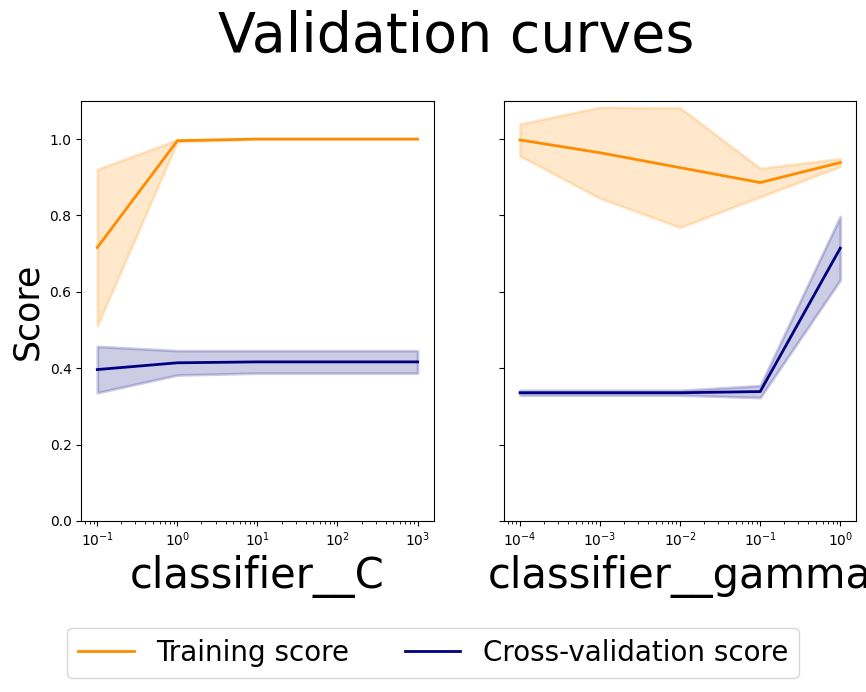

In [12]:
grid = grid_shno5
grid_params = {'classifier__C': [0.1, 1, 10, 100, 1000], 
              'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'classifier__kernel': ['rbf']
              } 


df = pd.DataFrame(grid.cv_results_)
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score', 
           'std_train_score']

# Following is from https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv
# https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
def pooled_var(stds):
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))


fig, axes = plt.subplots(1, len(grid_params), 
                         figsize = (5*len(grid_params), 7),
                         sharey='row')
axes[0].set_ylabel("Score", fontsize=25)
lw = 2

for idx, (param_name, param_range) in enumerate(grid_params.items()):
    grouped_df = df.groupby(f'param_{param_name}')[results]\
        .agg({'mean_train_score': 'mean',
              'mean_test_score': 'mean',
              'std_train_score': pooled_var,
              'std_test_score': pooled_var})

    previous_group = df.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=30)
    axes[idx].set_ylim(0.0, 1.1)
    axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                color="darkorange", lw=lw)
    axes[idx].fill_between(param_range, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                    grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                    color="darkorange", lw=lw)
    axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                color="navy", lw=lw)
    axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                    color="navy", lw=lw)
    axes[idx].set_xscale('log')

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=40)
fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

fig.subplots_adjust(bottom=0.25, top=0.85)  
plt.show()

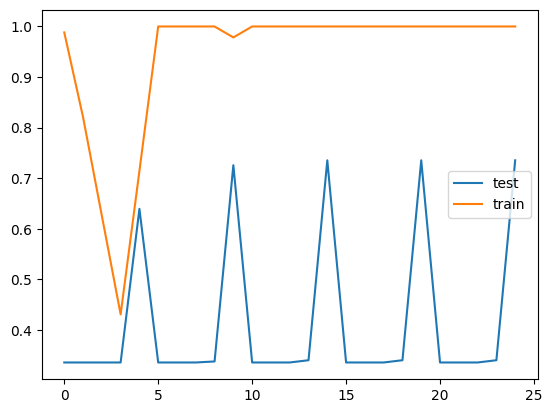

In [13]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

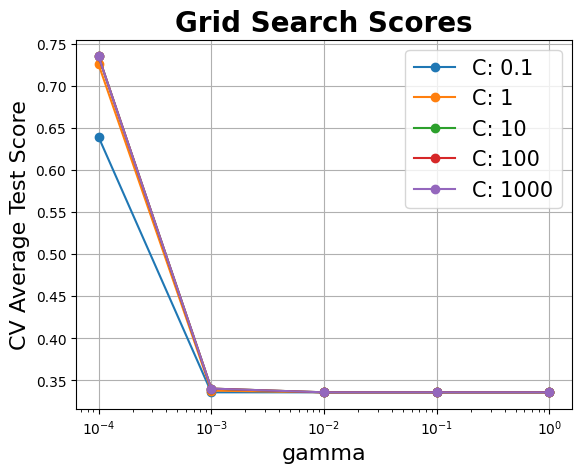

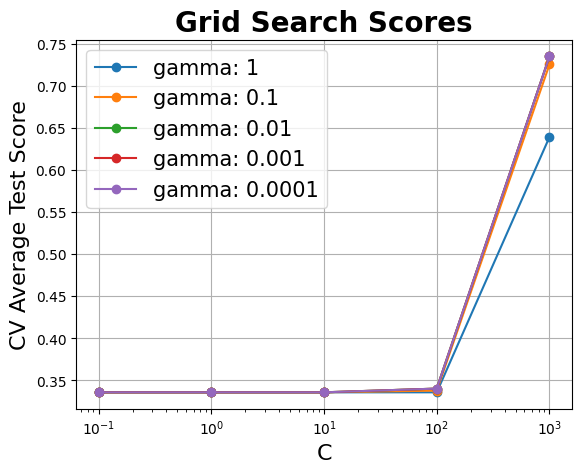

In [14]:
Cs = grid_params["classifier__C"]
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Function copied and adapted from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

#     scores_sd = cv_results['std_test_score']
#     scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Test Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    ax.set_xscale('log')

# Calling Method 
plot_grid_search(grid.cv_results_,  grid_params["classifier__gamma"],grid_params["classifier__C"], 'gamma', 'C')
plot_grid_search(grid.cv_results_,  grid_params["classifier__C"], grid_params["classifier__gamma"], 'C', 'gamma')

## Plot shno10

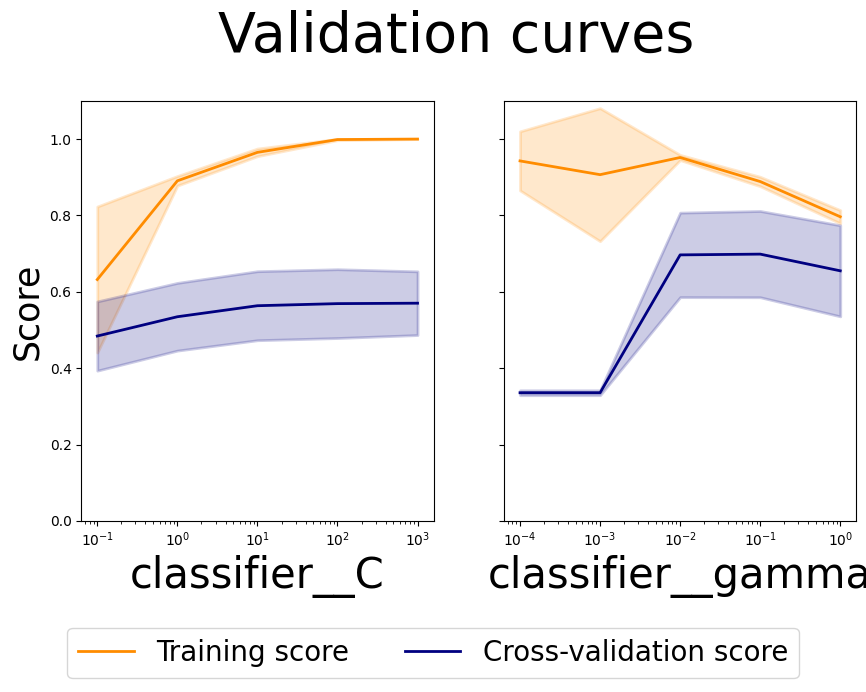

In [15]:
grid = grid_shno10
grid_params = {'classifier__C': [0.1, 1, 10, 100, 1000], 
              'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'classifier__kernel': ['rbf']
              } 


df = pd.DataFrame(grid.cv_results_)
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score', 
           'std_train_score']

# Following is from https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv
# https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
def pooled_var(stds):
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))


fig, axes = plt.subplots(1, len(grid_params), 
                         figsize = (5*len(grid_params), 7),
                         sharey='row')
axes[0].set_ylabel("Score", fontsize=25)
lw = 2

for idx, (param_name, param_range) in enumerate(grid_params.items()):
    grouped_df = df.groupby(f'param_{param_name}')[results]\
        .agg({'mean_train_score': 'mean',
              'mean_test_score': 'mean',
              'std_train_score': pooled_var,
              'std_test_score': pooled_var})

    previous_group = df.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=30)
    axes[idx].set_ylim(0.0, 1.1)
    axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                color="darkorange", lw=lw)
    axes[idx].fill_between(param_range, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                    grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                    color="darkorange", lw=lw)
    axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                color="navy", lw=lw)
    axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                    color="navy", lw=lw)
    axes[idx].set_xscale('log')

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=40)
fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

fig.subplots_adjust(bottom=0.25, top=0.85)  
plt.show()

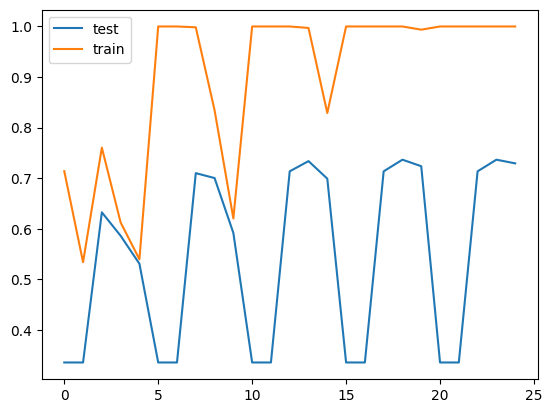

In [16]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

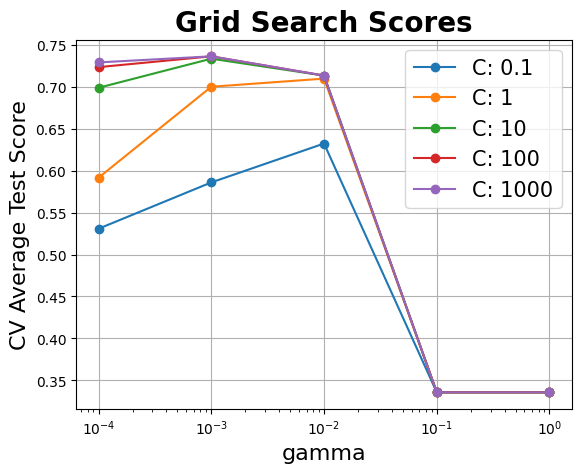

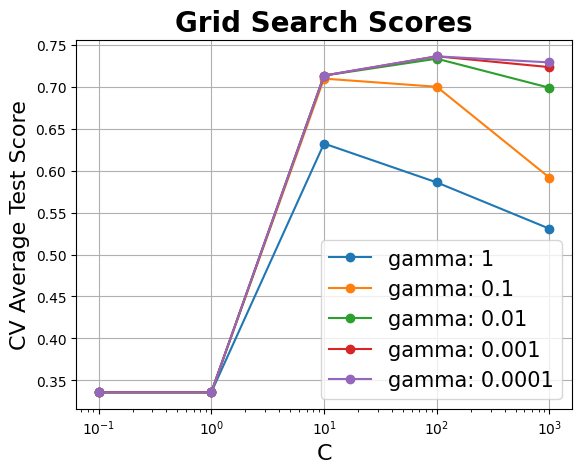

In [17]:
Cs = grid_params["classifier__C"]
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Function copied and adapted from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

#     scores_sd = cv_results['std_test_score']
#     scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Test Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    ax.set_xscale('log')

# Calling Method 
plot_grid_search(grid.cv_results_,  grid_params["classifier__gamma"],grid_params["classifier__C"], 'gamma', 'C')
plot_grid_search(grid.cv_results_,  grid_params["classifier__C"], grid_params["classifier__gamma"], 'C', 'gamma')

## Test

### Shno10

In [35]:
standardised_voice_test_os = pd.read_pickle("./audio_tables/voice_test_os_clean_stand_df")
y_test_match = standardised_voice_test_os.intendedEmo
X_test_match = standardised_voice_test_os.drop(columns=["intendedEmo"])

In [44]:
standardised_voice_test_mismatch = pd.read_pickle("./audio_tables/voice_test_mismatch_clean_stand_df")
y_test_mismatch = standardised_voice_test_mismatch.intendedEmo
X_test_mismatch = standardised_voice_test_mismatch.drop(columns=["intendedEmo"])

In [42]:
y_train_shno10 = stand_voice_train_os_shno10.intendedEmo
X_train_shno10 = stand_voice_train_os_shno10.drop(columns=["intendedEmo"])
best_svm_shno10 = SVC(C=100, gamma=0.001, random_state=4, kernel="rbf").fit(X_train_shno10, y_train_shno10)

In [37]:
y_pred_shno10 = best_svm_shno10.predict(X_test_match) #grid_shno10.best_estimator_.predict(X_test_match)

accuracy_shno10_match = accuracy_score(y_test_match,y_pred_shno10)*100
confusion_mat_shno10_match = confusion_matrix(y_test_match,y_pred_shno10)

# Printing the results
print("Accuracy for SVM is:",accuracy_shno10_match)
print("Confusion Matrix")
print(confusion_mat_shno10_match)

Accuracy for SVM is: 13.064516129032258
Confusion Matrix
[[  0   0 154   0   0   0]
 [  0   0  69   0   0   0]
 [  0   0  81   0   0   0]
 [  0   0  66   0   0   0]
 [  0   0 208   0   0   0]
 [  0   0  42   0   0   0]]


In [45]:
y_pred_shno10_mismatch = best_svm_shno10.predict(X_test_mismatch)

accuracy_shno10_mismatch = accuracy_score(y_test_mismatch,y_pred_shno10_mismatch)*100
confusion_mat_shno10_mismatch = confusion_matrix(y_test_mismatch,y_pred_shno10_mismatch)

# Printing the results
print("Accuracy for SVM is:",accuracy_shno10_mismatch)
print("Confusion Matrix")
print(confusion_mat_shno10_mismatch)

Accuracy for SVM is: 19.894082431498962
Confusion Matrix
[[   0    0  501    0    0    0]
 [   0    0  928    0    0    0]
 [   0    0  864    0    0    0]
 [   0    0  941    0    0    0]
 [   0    0   47    0    0    0]
 [   0    0 1062    0    0    0]]


### Shno5

In [43]:
y_train_shno5 = stand_voice_train_os_shno5.intendedEmo
X_train_shno5 = stand_voice_train_os_shno5.drop(columns=["intendedEmo"])
best_svm_shno5 = SVC(C=10, gamma=0.0001, random_state=4, kernel="rbf").fit(X_train_shno5, y_train_shno5)


y_pred_shno5 = best_svm_shno5.predict(X_test_match) #grid_shno10.best_estimator_.predict(X_test_match)

accuracy_shno5_match = accuracy_score(y_test_match,y_pred_shno5)*100
confusion_mat_shno5_match = confusion_matrix(y_test_match,y_pred_shno5)

# Printing the results
print("Accuracy for SVM is:",accuracy_shno5_match)
print("Confusion Matrix")
print(confusion_mat_shno5_match)

Accuracy for SVM is: 71.45161290322581
Confusion Matrix
[[131   7   3   9   4   0]
 [  3  41   5   2  17   1]
 [ 10   4  53   6   3   5]
 [ 14   7   7  30   8   0]
 [  3  18  13   0 174   0]
 [  1   6   8   0  13  14]]


In [46]:
y_pred_shno5_mismatch = best_svm_shno5.predict(X_test_mismatch)

accuracy_shno5_mismatch = accuracy_score(y_test_mismatch,y_pred_shno5_mismatch)*100
confusion_mat_shno5_mismatch = confusion_matrix(y_test_mismatch,y_pred_shno5_mismatch)

# Printing the results
print("Accuracy for SVM is:",accuracy_shno5_mismatch)
print("Confusion Matrix")
print(confusion_mat_shno5_mismatch)

Accuracy for SVM is: 28.57471793690997
Confusion Matrix
[[389  16  26  34  36   0]
 [223 273  93  40 274  25]
 [142  93 249  44 266  70]
 [427  58  95 178 181   2]
 [  8   2   4   1  32   0]
 [ 35 175 160  11 561 120]]
